In [1]:
%matplotlib inline  
from PIL import Image
import pytesseract
from skimage.filters import threshold_local
import argparse
import cv2
import os
import tempfile
import imutils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def set_image_dpi(file_path):
    """
    Return opencv2 image from file_path with a DPI of 300. Optimized for pytesseract.
    """
    if isinstance(file_path, str):
        im = Image.open(file_path)
    else:
        im = image
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return cv2.imread(temp_filename)

def plt_two_imgs(img1, img2, title1='Image1', title2='Image2'):
    plt.subplot(121), plt.imshow(img1, cmap='gray')
    plt.title(title1), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2, cmap='gray')
    plt.title(title2), plt.xticks([]), plt.yticks([])
    plt.show() 


In [3]:
imgs = ["test_imgs/img00.jpeg", "test_imgs/img01.jpg", "test_imgs/img02.jpg", "test_imgs/img03.jpg", "test_imgs/img04.jpg"]
img_name = 'test_imgs/whole_foods_in_frame.jpg'


In [4]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

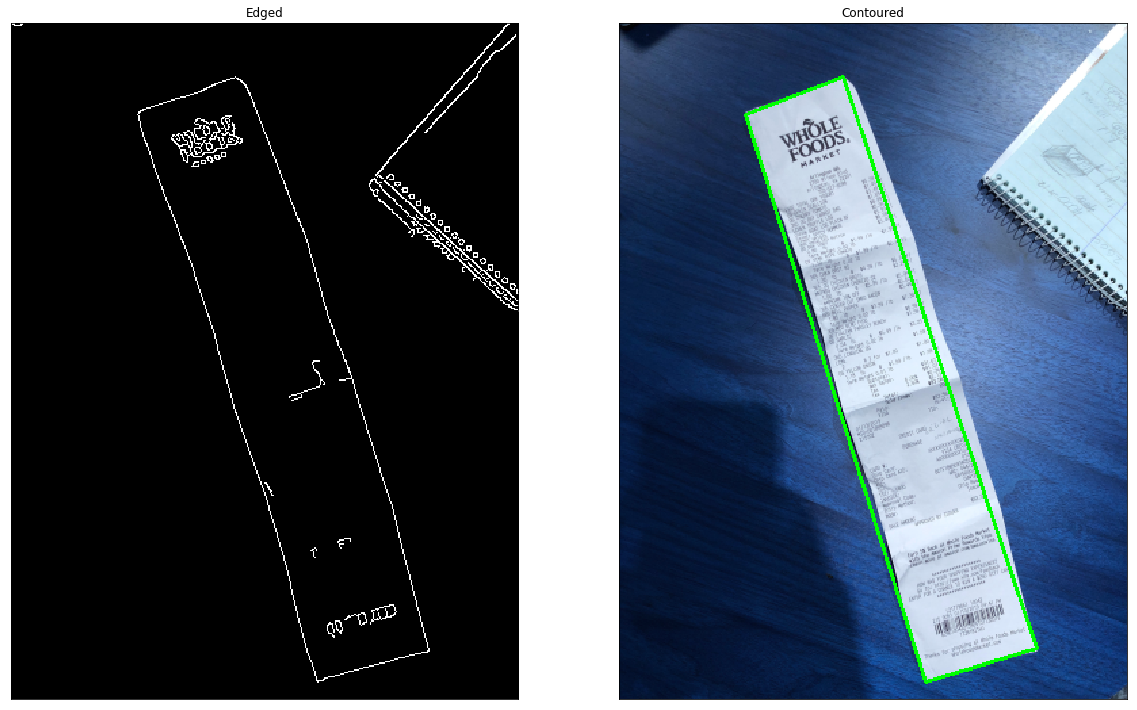

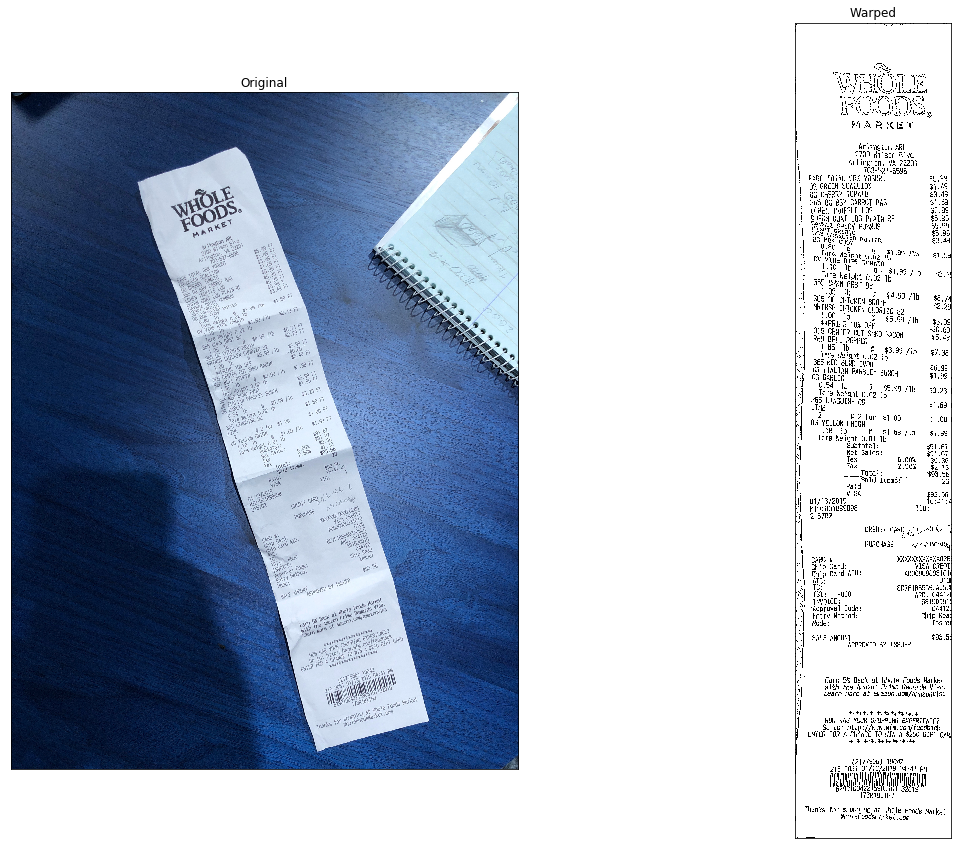

In [34]:
"""Trying to find a bounding box for the receipts, to cut out noise. Not that successful at the moment."""
plt.rcParams['figure.figsize'] = [20, 15]
def edge_detection(file_path):
    image = cv2.imread(file_path)
    ratio, resized_img = load_and_resize_img(image)
    edged = get_edges(resized_img)
    contoured_img, screenCnt = find_contours(edged, resized_img)
    plt_two_imgs(edged, contoured_img, 'Edged', 'Contoured')
    warped = four_point_transform(image, screenCnt.reshape(4, 2) * ratio)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    warped = (warped > T).astype("uint8") * 255
    plt_two_imgs(image, warped, 'Original', 'Warped')
    return warped
    
def load_and_resize_img(image):
    """
    Load image, compute ratio of old height to new heigh, clone and resize.
    """
    # Speeds up processing and its more accurate
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    image = imutils.resize(image, height=500)
    return ratio, image

def get_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    return edged

def find_contours(edged, image):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    screenCnt = None
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break
    if screenCnt is not None:
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    return image, screenCnt

warped = edge_detection(img_name)

In [35]:
image = set_image_dpi('test_imgs/mr_smiths_receipt.jpeg')
# Turn gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Preprocess Images
mb = cv2.medianBlur(gray, 5)
bf = cv2.bilateralFilter(gray, 9, 10, 200)
th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
at_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
at_gaussian = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

In [36]:
titles = ['Original Image',
          'Gray',
          'Median Blur',
          'Bilateral Filter',
          'Threshold',
          'Adaptive Gaussian Thresholding',
          'Adaptive Mean Thresholding']


images = [image, gray, mb, bf, th, at_gaussian, at_mean]

In [37]:
def run(titles, images, print_text=True):
    every_other = False
    plt.rcParams['figure.figsize'] = [15, 10]
    for i in range(len(titles)):
        if print_text:
            # print(titles[i])
            filename = "{}.png".format(os.getpid())
            cv2.imwrite(filename, images[i])
            text = pytesseract.image_to_string(Image.open(filename))
            os.remove(filename)
        if every_other:
            ax2 = plt.subplot(122)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            text2 = text

            plt.annotate(text2, (0,0), (0, -20), xycoords='axes fraction',
                         textcoords='offset points', va='top', transform=ax2.transAxes)
            plt.title(titles[i]), plt.xticks([]), plt.yticks([])
            plt.show()
            every_other = False
        else:
            ax1 = plt.subplot(121)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            text1 = text
            plt.annotate(text1, (0,0), (0, -20), xycoords='axes fraction',
                         textcoords='offset points', va='top', transform=ax1.transAxes)
            plt.imshow(images[i], cmap="gray", interpolation='bicubic')
            plt.title(titles[i]), plt.xticks([]), plt.yticks([])
            every_other = True
    # For odd number of graphs
    if every_other:
        plt.show()

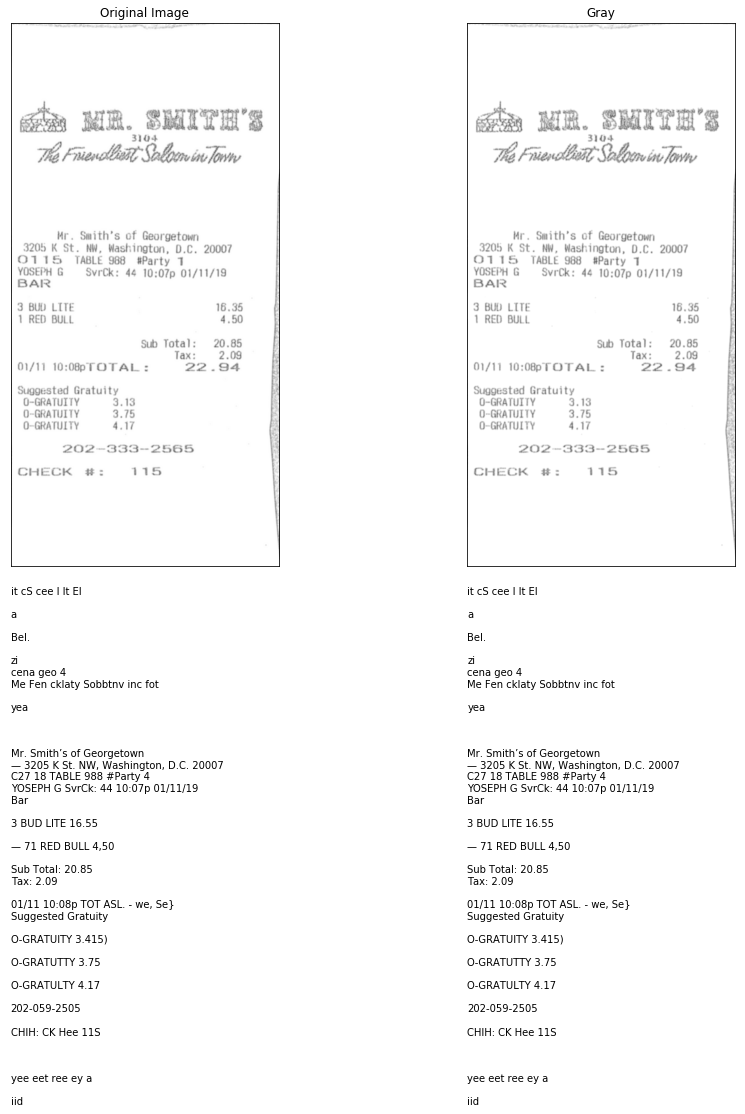

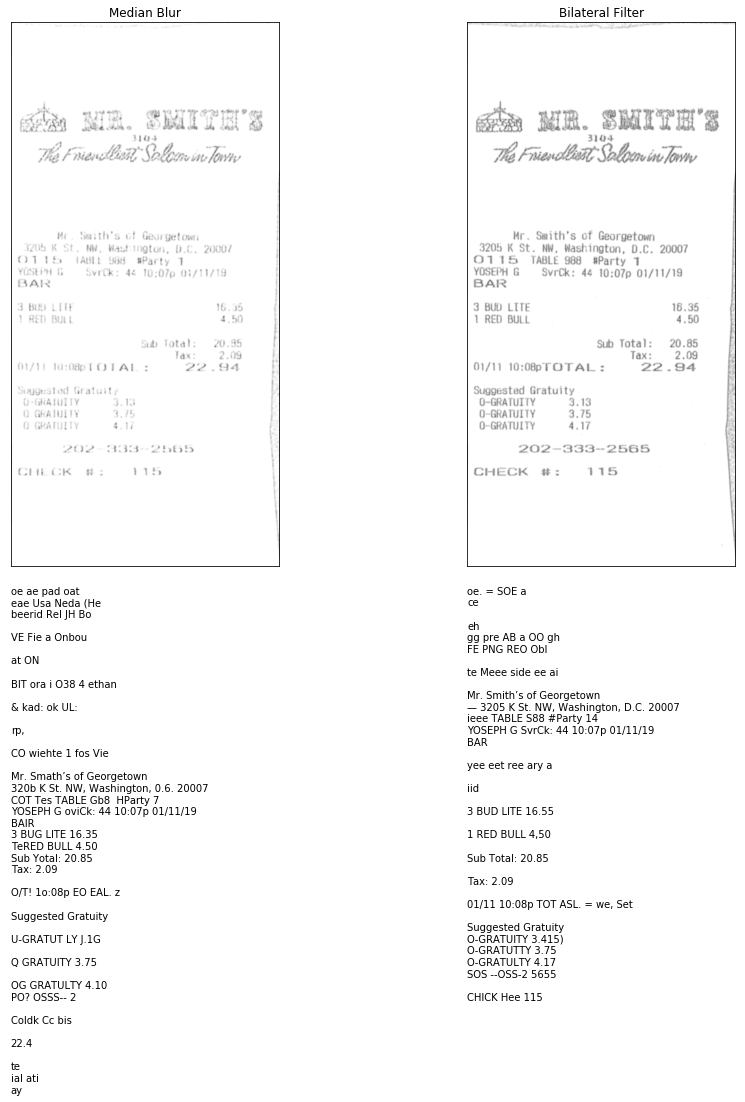

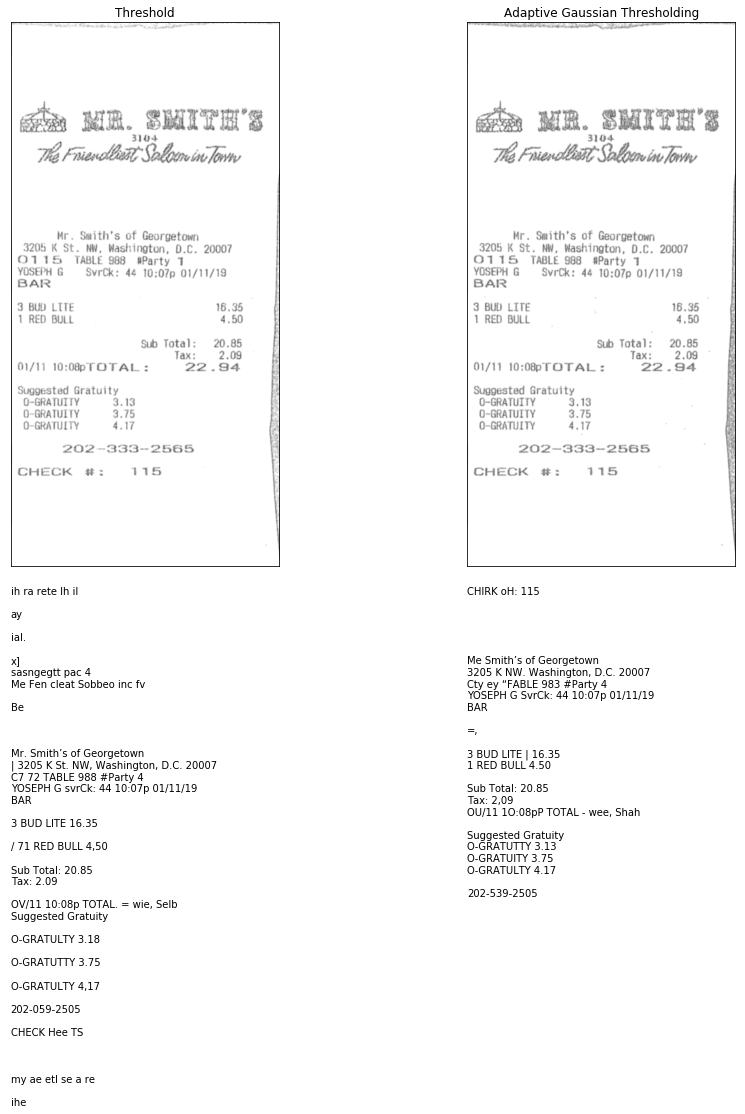

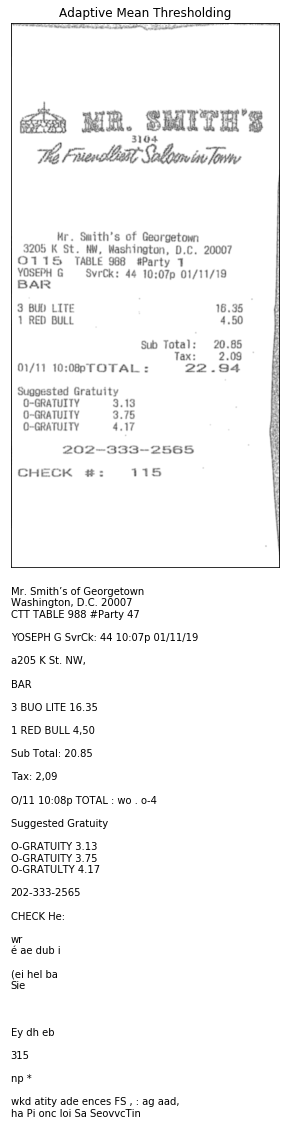

In [38]:
run(titles, images)

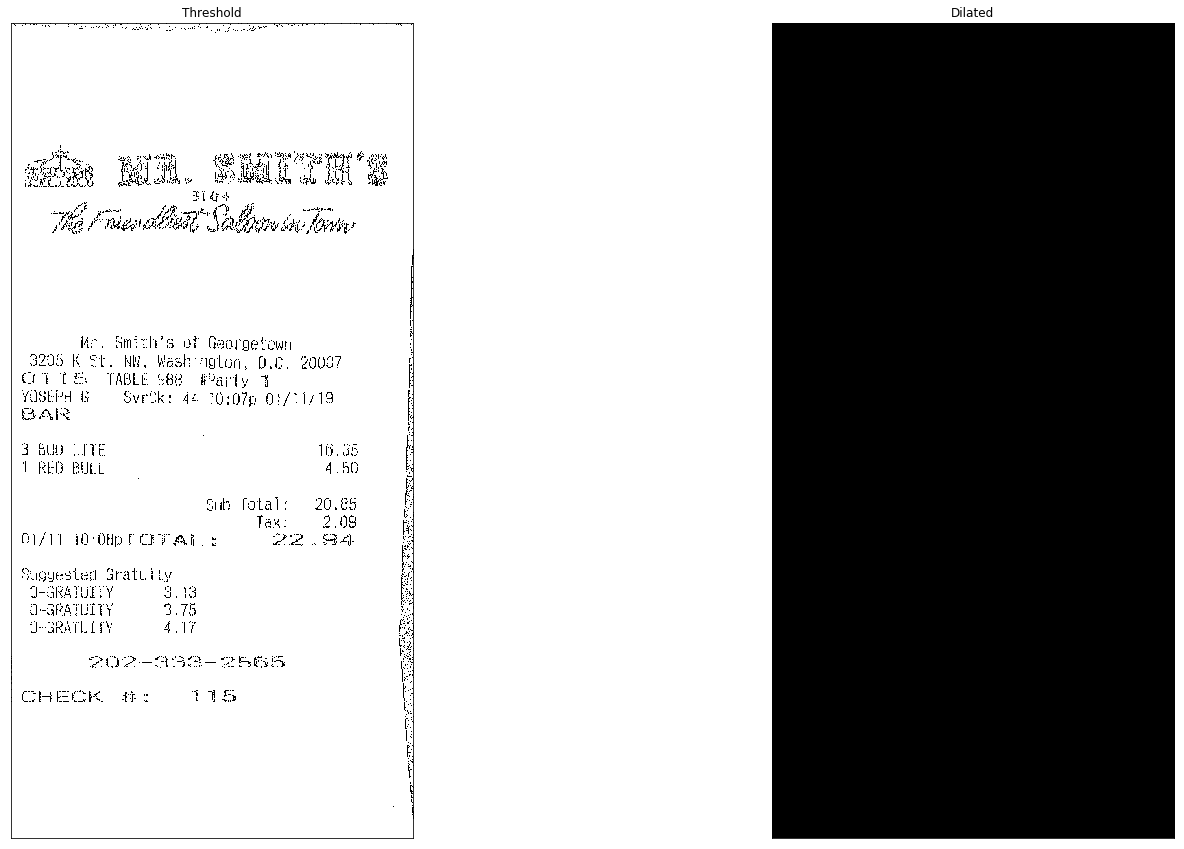

In [57]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
dilated = cv2.dilate(th, kernel,iterations=3) # dilate
plt.rcParams['figure.figsize'] = [25, 15]
plt_two_imgs(th, dilated, 'Threshold', 'Dilated')

In [43]:
import re

phone_regex = re.compile(
    r"([0-9]( |-)?)?(\(?[0-9]{3}\)?|[0-9]{3})( |-)?([0-9]{3}( |-)?[0-9]{4}|[a-zA-Z0-9]{7})"
)

def get_matches(line, regex):
    matches = regex.search(line)
    if matches:
        return matches.group(0)

print(get_matches('(860)9925720', phone_regex))

(860)9925720


In [49]:
raw_text = """
Holiday Inn Express & Suites Baltimore
West - Catonsville

5701 Baltimore National Pike

Catonsville

21228

MD

us

+14432512000

Hotels.com confirmation number 154773268702

Check-in Wednesday, January 16, 2019 (3 PM-2:00 AM
local time)

Check-out Thursday, January 17, 2019 (Before 11 AM local

time)

Your stay 1 night, 1 room

Cancellation policy Non-refundable

Amount paid $99.40

See full payment details below
"""

In [55]:
phone_regex = re.compile(
    r"([0-9]( |-)?)?(\(?[0-9]{3}\)?|[0-9]{3})( |-)?([0-9]{3}( |-)?[0-9]{4}|[0-9]{7})"
)

street_address_regex = re.compile(
    r"\d{1,3}.?\d{0,3}\s[a-zA-Z]{2,30}\s[a-zA-Z]{2,15}"
    # r"[ \w]{3,}([A-Za-z]\.)?([ \w]*\#\d+)?(\r\n| )[ \w]{3,},\x20[A-Za-z]{2}\x20\d{5}(-\d{4})?"
)

email_regex = re.compile(
    "\w+@[a-zA-Z_]+?\.[a-zA-Z]{2,3}"
)
print("Phone num:      %s" % get_matches(raw_text, phone_regex))
print("Email Address:  %s" % get_matches(raw_text, email_regex))
print("Street Address: %s" % get_matches(raw_text, street_address_regex))

Phone num:      14432512000
Email Address:  None
Street Address: 5701 Baltimore National
